In [1]:
%matplotlib inline

# !export OMP_NUM_THREADS=4
# !export OPENBLAS_NUM_THREADS=4

import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import euclidean_distances
from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import hungarian
import Cluster_Ensembles as CE
from scipy.optimize import linear_sum_assignment

np.random.seed(0)

# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
n_samples = 500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)


In [2]:
# check the output satisfy prob
# check the parameter stability

def ind(N,k):
    return np.ones((N,1)).dot(np.ones((1,k)))

def findMost(I, n):
    v = []
    for i1 in range(len(I)):
        v.append(np.sort(np.concatenate([I[i1][0:i1],I[i1][i1+1:]]))[n-1])
    return np.array(v)

# I: input; L: distance function; k: # of cluster
# c: scale factor >0; lamda1,lamda2: initial penalty parameters >0
# mu: step-factor >1; gamma: learning rate <1;
# ep1: threshold >0, <<1
                              
def sof(I, k, c, lamda1, lamda2, mu, gamma, ep1, ep2):
    N = I.shape[0]
    
    D1 = euclidean_distances(I,I)
    vec = findMost(D1,10)
    D1 = D1/np.sqrt(vec.reshape(1,N))/np.sqrt(vec.reshape(N,1))
    
    P = np.exp(-c*D1) # NxN
    wt = np.random.rand(N, k) # NxK
#     wt = np.copy(w0)
#     print 'w0 norm, ',np.linalg.norm(w0, 2)
    
#     print 'grad norm, ',np.linalg.norm(grad, 2),'wt norm, ',np.linalg.norm(wt, 2)
    
    count0 = 0
    while(lamda1 < 1./ep2 and lamda2 < 1./ep2):
        count1 = 0
        w0 = np.copy(wt)
        grad = 4*(( w0.dot(w0.T)-P )).dot(w0)
        tmp = np.ones((N,k))
        tmp[w0>=0] = 0
        grad += -lamda1*(tmp*(np.ones((N,k))))
        grad += 2*lamda2*(w0.dot(np.ones((k,k)))-np.ones((N,k)))
        wt = wt - gamma*grad
        while( np.linalg.norm(wt-w0, 2) > ep1):
            w0 = np.copy(wt)
            grad = 4*(( w0.dot(w0.T)-P )).dot(w0)
            tmp = np.ones((N,k))
            tmp[w0>=0] = 0
            grad += -lamda1*(tmp*(np.ones((N,k))))
            grad += 2*lamda2*(w0.dot(np.ones((k,k)))-np.ones((N,k)))
            wt = wt - gamma*grad
#             print count1, np.linalg.norm(wt-w0, 2), np.linalg.norm(wt, 2), np.linalg.norm(grad, 2)
            count1 += 1
#             if count1%100==0:
#                 print count1, np.linalg.norm(wt-w0, 2), np.linalg.norm(wt, 2), np.linalg.norm(grad, 2)
# #                 print count1

#                 if count1 == 300:
#                     break
#             print 'grad norm, ',np.linalg.norm(grad, 2),'wt norm, ',np.linalg.norm(wt, 2)
#             break
        lamda1 = lamda1*mu
        lamda2 = lamda2*mu
        gamma = gamma/mu
#         print 'count0, count1, lamda1, lamda2, gamma'
#         print count0, count1, lamda1, lamda2, gamma
        count0 += 1
        if count1==0:
            print count0, lamda1, lamda2, gamma
#             print wt
            break
#         if count1 == 300: break

#     print wt
    print 'absolute sum', np.sum(np.sum(wt,axis=1))
#     print (np.sum(wt,axis=1))
    return np.argmax(wt,axis=1)

# learning rate need to be small for converge
#     print sof(X, k=2., c=1., lamda1=0.1, lamda2=0.1, mu=1.1,
#               gamma=0.0001, ep1=0.01, ep2=0.01 )



#     https://github.com/scikit-learn/scikit-learn/blob/51a765a/sklearn/metrics/cluster/supervised.py#L90
# https://github.com/zenweasel/python-snippets/blob/master/waterworks/ClusterMetrics.py
# http://stats.stackexchange.com/questions/89030/rand-index-calculation
from scipy.misc import comb

def rand_score(clusters, classes):

    tp_plus_fp = comb(np.bincount(clusters), 2).sum()
    tp_plus_fn = comb(np.bincount(classes), 2).sum()
    A = np.c_[(clusters, classes)]
    tp = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(clusters))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)


In [17]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

def train(times, X, y):
    t0 = time.time()
#     times = 1
    # for lea in [0.0001, 0.00001, 0.000001]:
    lea = .00001
    print 'learning, ', lea
    ari,ri,accu = 0.,0.,0.
    for ddd in range(times):
        y_pred_old = sof(X, k=len(np.unique(y)), c=1, 
                                 lamda1=10,lamda2=10, mu=2, 
                                 gamma=lea, ep1=0.0001, ep2=0.0001 )
        row, col = linear_sum_assignment(-confusion_matrix(y, y_pred_old))
        y_pred = np.copy(y_pred_old)
        for i, q in enumerate(col):
            y_pred[y_pred_old==q] = i
        ari += adjusted_rand_score(y,y_pred)
        ri += rand_score(y, y_pred)
        accu += accuracy_score(y,y_pred)
        print accuracy_score(y,y_pred),rand_score(y, y_pred)
    # print 'ARI: ', adjusted_rand_score(y,y_pred)
    # print 'RI: ', rand_score(y, y_pred)
    # print 'Accu: ', accuracy_score(y,y_pred)
    # print confusion_matrix(y, y_pred)
    # print y_pred
    print '\ttime, ', time.time()-t0
    print '\tARI: ', ari/times
    print '\tRI: ', ri/times
    print '\tAccu: ', accu/times
    print ''
    
train(20, X, y)
    

learning,  1e-05
absolute sum 145.868619935
0.926666666667 0.912393736018
absolute sum 145.868659716
0.906666666667 0.89225950783
absolute sum 145.868492857
0.92 0.905503355705
absolute sum 145.868684281
0.926666666667 0.912393736018
absolute sum 145.869110125
0.933333333333 0.919463087248
absolute sum 145.868562575
0.92 0.905503355705
absolute sum 145.868550264
0.92 0.905503355705
absolute sum 145.867711208
0.9 0.885906040268
absolute sum 145.868306238
0.906666666667 0.89225950783
absolute sum 145.869100933
0.933333333333 0.919463087248
absolute sum 145.868611424
0.92 0.905503355705
absolute sum 145.868246061
0.913333333333 0.898791946309
absolute sum 145.869292376
0.906666666667 0.89225950783
absolute sum 145.868696411
0.94 0.926711409396
absolute sum 145.869236291
0.906666666667 0.89225950783
absolute sum 145.868455246
0.906666666667 0.89225950783
absolute sum 145.868643681
0.933333333333 0.919463087248
absolute sum 145.868530774
0.92 0.905503355705
absolute sum 145.868690485
0.92 0

In [23]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

def train(times, X, y):
    t0 = time.time()
#     times = 1
    # for lea in [0.0001, 0.00001, 0.000001]:
    lea = .00001
    print 'learning, ', lea
    ari,ri,accu = 0.,0.,0.
    for ddd in range(times):
        y_pred_old = sof(X, k=len(np.unique(y)), c=1, 
                                 lamda1=0.1,lamda2=0.1, mu=2, 
                                 gamma=lea, ep1=0.0001, ep2=0.0001 )
        row, col = linear_sum_assignment(-confusion_matrix(y, y_pred_old))
        y_pred = np.copy(y_pred_old)
        for i, q in enumerate(col):
            y_pred[y_pred_old==q] = i
        ari += adjusted_rand_score(y,y_pred)
        ri += rand_score(y, y_pred)
        accu += accuracy_score(y,y_pred)
        print accuracy_score(y,y_pred),rand_score(y, y_pred)
    # print 'ARI: ', adjusted_rand_score(y,y_pred)
    # print 'RI: ', rand_score(y, y_pred)
    # print 'Accu: ', accuracy_score(y,y_pred)
    # print confusion_matrix(y, y_pred)
    # print y_pred
    print '\ttime, ', time.time()-t0
    print '\tARI: ', ari/times
    print '\tRI: ', ri/times
    print '\tAccu: ', accu/times
    print ''
    
train(20, X, y)
    

learning,  1e-05
0.94 0.926711409396
0.933333333333 0.919463087248
0.913333333333 0.898791946309
0.933333333333 0.919463087248
0.933333333333 0.919463087248
0.933333333333 0.919463087248
0.9 0.885906040268
0.906666666667 0.89225950783
0.873333333333 0.857986577181
0.9 0.885906040268
0.933333333333 0.919463087248
0.92 0.905503355705
0.88 0.867919463087
0.933333333333 0.919463087248
0.9 0.885906040268
0.94 0.926711409396
0.846666666667 0.832393736018
0.9 0.885906040268
0.9 0.885906040268
0.706666666667 0.756331096197
	time,  93.3312900066
	ARI:  0.753631156289
	RI:  0.890545861298
	Accu:  0.901333333333



In [24]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

def train(times, X, y):
    t0 = time.time()
#     times = 1
    # for lea in [0.0001, 0.00001, 0.000001]:
    lea = .00001
    print 'learning, ', lea
    ari,ri,accu = 0.,0.,0.
    for ddd in range(times):
        y_pred_old = sof(X, k=len(np.unique(y)), c=1, 
                                 lamda1=0.01,lamda2=0.01, mu=2, 
                                 gamma=lea, ep1=0.0001, ep2=0.0001 )
        row, col = linear_sum_assignment(-confusion_matrix(y, y_pred_old))
        y_pred = np.copy(y_pred_old)
        for i, q in enumerate(col):
            y_pred[y_pred_old==q] = i
        ari += adjusted_rand_score(y,y_pred)
        ri += rand_score(y, y_pred)
        accu += accuracy_score(y,y_pred)
        print accuracy_score(y,y_pred),rand_score(y, y_pred)
    # print 'ARI: ', adjusted_rand_score(y,y_pred)
    # print 'RI: ', rand_score(y, y_pred)
    # print 'Accu: ', accuracy_score(y,y_pred)
    # print confusion_matrix(y, y_pred)
    # print y_pred
    print '\ttime, ', time.time()-t0
    print '\tARI: ', ari/times
    print '\tRI: ', ri/times
    print '\tAccu: ', accu/times
    print ''
    
train(20, X, y)
    

learning,  1e-05
0.933333333333 0.919463087248
0.933333333333 0.919463087248
0.593333333333 0.678568232662
0.913333333333 0.897718120805
0.92 0.905503355705
0.96 0.949530201342
0.66 0.702102908277
0.773333333333 0.774138702461
0.933333333333 0.919463087248
0.933333333333 0.919463087248
0.926666666667 0.912393736018
0.913333333333 0.898791946309
0.753333333333 0.760984340045
0.893333333333 0.879731543624
0.926666666667 0.912393736018
0.893333333333 0.879731543624
0.926666666667 0.912393736018
0.86 0.846711409396
0.94 0.926711409396
0.933333333333 0.919463087248
	time,  112.842829943
	ARI:  0.712403452828
	RI:  0.871736017897
	Accu:  0.876



In [32]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

def train(times, X, y):
    t0 = time.time()
#     times = 1
    # for lea in [0.0001, 0.00001, 0.000001]:
    lea = .00001
    print 'learning, ', lea
    ari,ri,accu = 0.,0.,0.
    for ddd in range(times):
        y_pred_old = sof(X, k=len(np.unique(y)), c=1, 
                                 lamda1=10,lamda2=10, mu=2, 
                                 gamma=lea, ep1=0.0001, ep2=0.0001 )
        row, col = linear_sum_assignment(-confusion_matrix(y, y_pred_old))
        y_pred = np.copy(y_pred_old)
        for i, q in enumerate(col):
            y_pred[y_pred_old==q] = i
        ari += adjusted_rand_score(y,y_pred)
        ri += rand_score(y, y_pred)
        accu += accuracy_score(y,y_pred)
        print accuracy_score(y,y_pred),rand_score(y, y_pred)
    # print 'ARI: ', adjusted_rand_score(y,y_pred)
    # print 'RI: ', rand_score(y, y_pred)
    # print 'Accu: ', accuracy_score(y,y_pred)
    # print confusion_matrix(y, y_pred)
    # print y_pred
    print '\ttime, ', time.time()-t0
    print '\tARI: ', ari/times
    print '\tRI: ', ri/times
    print '\tAccu: ', accu/times
    print ''
    
train(20, X, y)
    

learning,  1e-05
0.9 0.885906040268
0.946666666667 0.934138702461
0.933333333333 0.919463087248
0.906666666667 0.89225950783
0.906666666667 0.89225950783
0.926666666667 0.912393736018
0.926666666667 0.912393736018
0.913333333333 0.898791946309
0.9 0.885906040268
0.933333333333 0.919463087248
0.926666666667 0.912393736018
0.913333333333 0.898791946309
0.926666666667 0.912393736018
0.906666666667 0.89225950783
0.926666666667 0.912393736018
0.906666666667 0.89225950783
0.9 0.885906040268
0.906666666667 0.89225950783
0.9 0.885906040268
0.926666666667 0.912393736018
	time,  173.131958008
	ARI:  0.780340650875
	RI:  0.902496644295
	Accu:  0.916666666667



/usr/local/lib/python2.7/dist-packages/sklearn/manifold/spectral_embedding_.py:226: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python2.7/dist-packages/sklearn/cluster/hierarchical.py:167: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  n_components=n_components)


absolute sum 472.613730771
absolute sum

/usr/local/lib/python2.7/dist-packages/sklearn/cluster/hierarchical.py:368: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  n_components=n_components)
/usr/local/lib/python2.7/dist-packages/sklearn/cluster/hierarchical.py:167: UserWarning: the number of connected components of the connectivity matrix is 3 > 1. Completing it to avoid stopping the tree early.
  n_components=n_components)


 472.601099372
absolute sum

/usr/local/lib/python2.7/dist-packages/sklearn/cluster/hierarchical.py:368: UserWarning: the number of connected components of the connectivity matrix is 3 > 1. Completing it to avoid stopping the tree early.
  n_components=n_components)
/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


 484.717571829


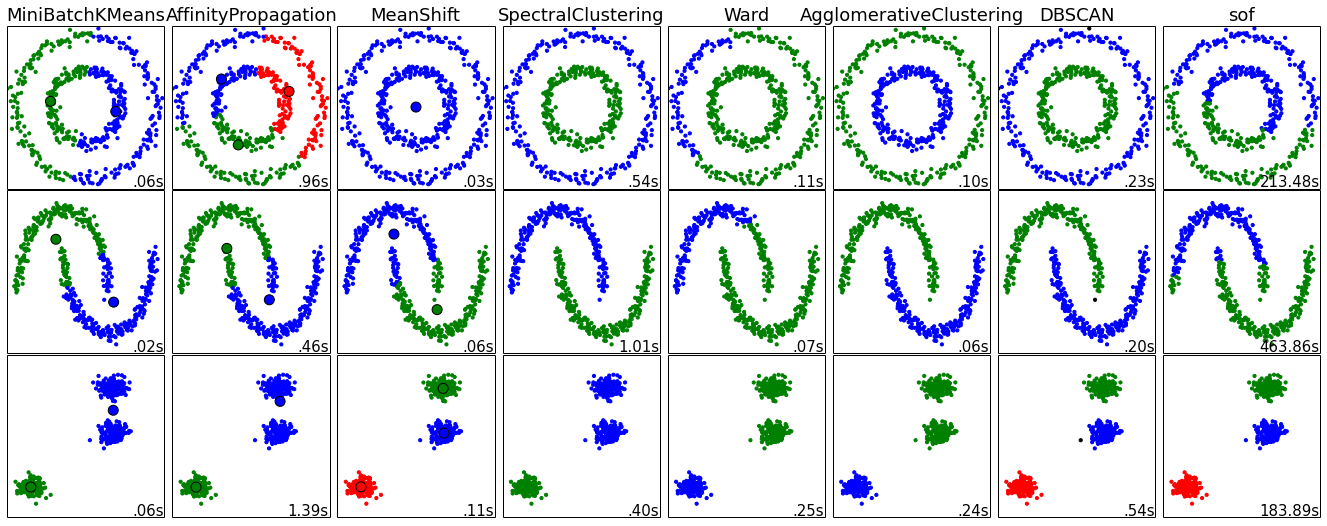

In [8]:
clustering_names = [
    'MiniBatchKMeans', 'AffinityPropagation', 'MeanShift',
    'SpectralClustering', 'Ward', 'AgglomerativeClustering',
    'DBSCAN','sof']
# clustering_names = ['sof']


plt.figure(figsize=(len(clustering_names) * 2 + 3, 9.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

# datasets = [noisy_circles, noisy_moons, blobs, no_structure]
datasets = [noisy_circles, noisy_moons,blobs]
for i_dataset, dataset in enumerate(datasets):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    
    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=0.3)

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=10)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # create clustering estimators
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=2)
    ward = cluster.AgglomerativeClustering(n_clusters=2, linkage='ward',
                                           connectivity=connectivity)
    spectral = cluster.SpectralClustering(n_clusters=2,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")
    
    dbscan = cluster.DBSCAN(eps=.2)
    affinity_propagation = cluster.AffinityPropagation(damping=.9,
                                                       preference=-200)

    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock", n_clusters=2,
        connectivity=connectivity)

    clustering_algorithms = [
        two_means, affinity_propagation, ms, spectral, ward, average_linkage,
        dbscan, sof]
#     clustering_algorithms = [sof]
    
    for name, algorithm in zip(clustering_names, clustering_algorithms):
        # predict cluster memberships
        t0 = time.time()
        if name != 'sof':
            algorithm.fit(X)
            t1 = time.time()
            if hasattr(algorithm, 'labels_'):
                y_pred = algorithm.labels_.astype(np.int)
            else:
                y_pred = algorithm.predict(X)
        else:
            y_pred = sof(X, k=len(np.unique(y)), c=1, 
                         lamda1=10,lamda2=10, mu=2, 
                         gamma=0.00001, ep1=0.0001, ep2=0.0001 )
            t1 = time.time()

        # plot
        plt.subplot(4, len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)
        plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

        if hasattr(algorithm, 'cluster_centers_'):
            centers = algorithm.cluster_centers_
            center_colors = colors[:len(centers)]
            plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1
#         break
#     break

plt.show()

